In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
import warnings

warnings.filterwarnings("ignore")

In [24]:
petr = yf.download('PETR4.SA', period='5y')
petr = petr[['High', 'Low', 'Close']]
petr

[*********************100%***********************]  1 of 1 completed


,High,Low,Close
Date,,,
2019-05-09,27.120001,26.639999,26.830000
2019-05-10,26.920000,26.420000,26.680000
2019-05-13,26.469999,25.820000,25.900000
2019-05-14,26.230000,25.850000,26.000000
2019-05-15,25.889999,25.660000,25.879999
...,...,...,...
2024-05-03,40.689999,39.450001,39.889999
2024-05-06,40.360001,39.720001,40.160000
2024-05-07,40.650002,40.000000,40.650002


In [25]:
def calcular_atr(dataframe, periodo_atr=14):

    novo_df = dataframe.copy()
    # Calcular True Range (TR)
    novo_df['TR'] = novo_df[['High', 'Low', 'Close']].apply(lambda x: max(x) - min(x), axis=1)

    # Calcular Average True Range (ATR)
    novo_df['ATR'] = novo_df['TR'].rolling(window=periodo_atr).mean()

    return novo_df

In [26]:
def calcular_bandas_keltner(df, periodo_ema=20, multiplicador_atr=2):
    
    
    dataframe = calcular_atr(df,periodo_ema)
    atr = dataframe['ATR']
    
    # Calcular a Média Móvel Exponencial (EMA)
    dataframe['EMA'] = dataframe['Close'].ewm(span = periodo_ema).mean()



    # Calcular as Bandas de Keltner
    dataframe['Delta'] = (multiplicador_atr * atr) 
    
    dataframe['UpperBand'] = dataframe['EMA'] + dataframe['Delta']
    dataframe['LowerBand'] = dataframe['EMA'] - dataframe['Delta'] 
    

    return dataframe[['Close','EMA', 'UpperBand', 'LowerBand']]

In [27]:
keltner = calcular_bandas_keltner(petr,60,5)

                Close        EMA  UpperBand  LowerBand
Date                                                  
2024-05-03  39.889999  39.347922  44.203755  34.492089
2024-05-06  40.160000  39.374548  44.193714  34.555381
2024-05-07  40.650002  39.416366  44.224699  34.608033
2024-05-08  41.270000  39.477141  44.321307  34.632974
2024-05-09  41.610001  39.547071  44.380404  34.713738


<Axes: xlabel='Date'>

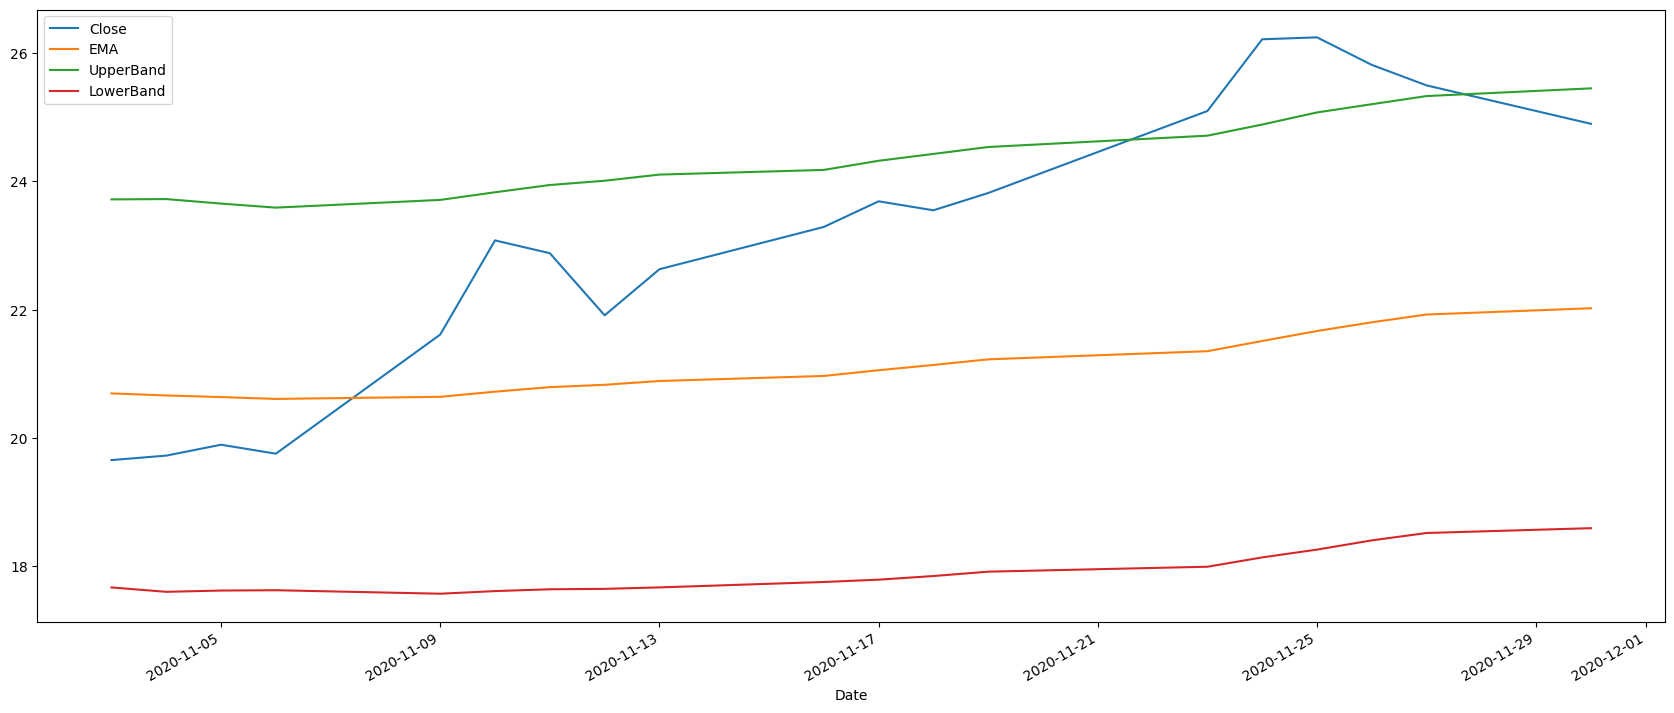

In [39]:
print(keltner.tail(5))
keltner.loc[(keltner.index>'2020-11-01') & (keltner.index<'2020-12-01') ].plot(figsize=(21,9))

In [29]:
short_entrie = keltner['Close'] > keltner['UpperBand']
entrie = keltner['Close'] < keltner['LowerBand']
exits = round(keltner['Close'],0) == round(keltner['EMA'],0)


In [36]:
short_entrie.loc[short_entrie == True]

Date
2019-10-31    True
2020-11-23    True
2020-11-24    True
2020-11-25    True
2020-11-26    True
2020-11-27    True
2020-12-01    True
2020-12-02    True
2020-12-03    True
2020-12-04    True
2020-12-07    True
2020-12-08    True
2020-12-09    True
2020-12-10    True
2020-12-11    True
2020-12-14    True
2020-12-15    True
2020-12-16    True
2020-12-17    True
2020-12-18    True
2020-12-28    True
2020-12-29    True
2020-12-30    True
2021-01-04    True
2021-01-05    True
2021-01-06    True
2021-01-07    True
2021-01-08    True
2021-01-11    True
2021-01-12    True
2022-01-26    True
2022-01-27    True
2022-08-08    True
2022-08-09    True
2022-08-10    True
2023-06-09    True
2023-06-12    True
2023-06-21    True
2023-06-22    True
2023-10-13    True
2023-10-16    True
2023-10-17    True
2023-10-18    True
2023-10-19    True
2023-10-20    True
2024-01-29    True
2024-01-31    True
2024-02-01    True
2024-02-05    True
2024-02-06    True
2024-02-07    True
2024-02-08    True
2024-02

In [31]:
backtest = vbt.Portfolio.from_signals(close=keltner['Close'] , entries=entrie, short_entries= short_entrie , exits=exits)

In [32]:
backtest.stats()

Start                         2019-05-09 00:00:00
End                           2024-05-09 00:00:00
Period                                       1244
Start Value                                 100.0
End Value                               92.249582
Total Return [%]                        -7.750418
Benchmark Return [%]                    55.087591
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        58.014131
Max Drawdown Duration                       563.0
Total Trades                                    7
Total Closed Trades                             6
Total Open Trades                               1
Open Trade PnL                         -55.155024
Win Rate [%]                            83.333333
Best Trade [%]                          31.118982
Worst Trade [%]                        -29.263634
Avg Winning Trade [%]                   16.058647
Avg Losing Trade [%]                   -29.263634


In [33]:
backtest.trades.plots()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '9dfe8820-d8a7-4472-8577-18aff7feff4a',
              'x': array([datetime.datetime(2019, 5, 9, 0, 0),
                          datetime.datetime(2019, 5, 10, 0, 0),
                          datetime.datetime(2019, 5, 13, 0, 0), ...,
                          datetime.datetime(2024, 5, 7, 0, 0),
                          datetime.datetime(2024, 5, 8, 0, 0),
                          datetime.datetime(2024, 5, 9, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([26.82999992, 26.68000031, 25.89999962, ..., 40.65000153, 41.27000046,
                          41.61000061]),
              'yaxis': 'y'},
             {'customdata': array([[0, 0, 3.290556170068973, 0.0, 'Short'],
                                   [1, 1, 4.340119411239389, 0.0, 'Long'],
  